In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from numpy import arange, sin, pi, random
from scipy.stats import norm
import tensorflow as tf
import math
import os
import copy

In [2]:
np.random.seed(1234)

sequence_length = 100
epochs = 15
batch_size = 100

In [3]:
def gen_wave():
    """ Generate a synthetic wave by adding up a few sine waves and some noise return: the final wave
    """
    t = np.arange(0.0, 20.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.2, len(t))
    wave1 = wave1 + noise
    wave2 = sin(2 * pi * t)
     
    t_rider = arange(0.0, 0.5, 0.01)
    wave3 = 0.5*sin(10 * pi * t_rider)
     
    insert = round(0.9 * len(t))
    wave1[insert:insert + 50] = wave1[insert:insert + 50] + wave3
    wave1[1700] = wave1[1700] + 0.65
    return wave1 + wave2

In [4]:
def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [5]:
def get_split_prep_data(train_start, train_end, test_start, test_end):
    data = gen_wave()
    print("Length of Data", len(data))

    # train data
    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    #result, result_mean = z_norm(result)
 
    X_train = result[:, :-1]
    y_train = result[:, -1]
    
    # test data
    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  #
    #result, result_mean = z_norm(result)
    X_test = result[:, :-1]
    y_test = result[:, -1]
      
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    y_test  = np.reshape(y_test, (y_test.shape[0], 1))
    print("Shape X_train", np.shape(X_train))
    print("Shape y_train", np.shape(y_train))
    print("Shape X_test", np.shape(X_test))
    print("Shape y_test", np.shape(y_test))
    
    return X_train, y_train, X_test, y_test

In [6]:
X_train, y_train, X_test, y_test = get_split_prep_data(0, 1400, 1500, 2000)

Length of Data 2000
Shape X_train (1300, 99)
Shape y_train (1300, 1)
Shape X_test (400, 99)
Shape y_test (400, 1)


In [7]:
from build_model_basic import * 
## Parameters defined in the .py file

In [8]:
def generate_batch(batch_size, X, Y): 
    idx = np.random.choice(range(len(X)), batch_size, replace=False)
    batch_X = [X[i] for i in idx]
    batch_Y = [Y[i] for i in idx]
    return np.array(batch_X), np.array(batch_Y)

In [9]:
train_losses = []
val_losses = []
batch_size  = 50
total_iteractions = 2000

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output = generate_batch(batch_size, X_train, y_train)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1, input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1, output_dim) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        if not i%50:
            print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)

1.89062
0.0962218
0.0786127
0.0776968
0.0679259
0.0779311
0.0820625
0.0827531
0.0826069
0.0595292
0.0553645
0.0362141
0.0504952
0.049848
0.0469637
0.0674422
0.0519149
0.0483553
0.0465948
0.0471203
0.0531693
0.0682399
0.0628608
0.0436131
0.0372327
0.0441631
0.0495503
0.0531873
0.0568791
0.0443864
0.0333048
0.0572383
0.0713825
0.0436454
0.0421978
0.0416858
0.0482837
0.0348973
0.0600567
0.0419571
Checkpoint saved at:  ./univariate_ts_model0


In [10]:
rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: X_test[:,t].reshape(-1, input_dim) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([len(X_test), output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


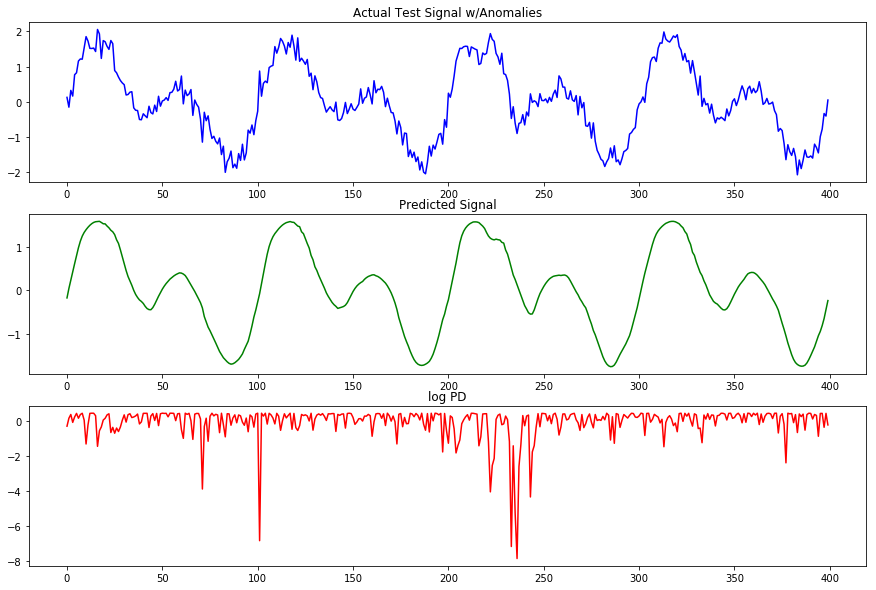

In [11]:
plt.figure(figsize=(15,10))
plt.figure(1)
plt.subplot(311)
plt.title("Actual Test Signal w/Anomalies")
plt.plot(y_test[:len(y_test)], 'b')

plt.subplot(312)
plt.title("Predicted Signal")
plt.plot(final_preds[0][:len(y_test)], 'g')

plt.subplot(313)
error_vectors = y_test - final_preds[0]
mean = np.mean(error_vectors)
std = np.std(error_vectors)
p_values = norm(loc=mean, scale=std).logpdf(error_vectors)
plt.title("log PD")
plt.plot(p_values, 'r')

plt.show()

In [ ]:
help(norm.logpdf)